## Welcome to the tutorial on how to load the BBBD dataset! We’re using Python in this tutorial.

If you have never used Python before, make sure you download it from the official website, and use a text editor like Visual Studio Code so you can write python scripts to work with this dataset.

This dataset consists of 5 experiments - each formatted in the Brain Imaging Dataset Structure (BIDS). In this structure, files are first segregated subject-wise (participant), within which they are then segregated session-wise (recording condition), and for each of these sessions you can expect directories for either eeg (electroencephalography - brain) and/or beh (behavioral - physiological signals like ecg, head motion, gaze tracking, respiration) if available. Each of these directories stores respective signals recorded for a particular subject, for a particular session, over multiple stimuli (videos watched by the subject). You can run the following cell to download them all!

In [ ]:
import requests
import zipfile
import os

def bbbd_download_unzip(expno, output_dir, output_file=None):
    url = f'https://fcp-indi.s3.amazonaws.com/data/Projects/CUNY_MADSEN/BBBD/bids_data/experiment{expno}.zip'
    if output_file is None:
        output_file = os.path.join(output_dir, url.split("/")[-1])
    os.makedirs(output_dir, exist_ok=True)
    
    # Download 
    print(f"Downloading from {url}...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(output_file, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        print(f"Download completed: {output_file}")
    else:
        print(f"Failed to download. Status code: {response.status_code}")
        return None
    
    # Unzip
    if zipfile.is_zipfile(output_file):
        print(f"Unzipping {output_file}...")
        with zipfile.ZipFile(output_file, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
        print(f"Extracted to: {output_dir}")
        os.remove(output_file)
    else:
        print(f"{output_file} is not a ZIP file, skipping extraction.")
    return output_file

download_dir = r'.\bbbd_datasets'
expnos = [1,2,3,4,5]
for expno in expnos:
    bbbd_download_unzip(expno, download_dir)


Each file (be it .bdf, .tsv, .tsv.gzip) has its own corresponding json file that stores the metadata.

You will find that in the “eeg” directory, EEG signals are stored in the bdf format, and its corresponding metadata has the same filename but with the json format. For the same filename you will also find the events file (.tsv format) that has the timing for the starting and the ending samples, and the duration this event lasts for (time for a sample, i.e, 1/fs). This is also explained in their corresponding json files. 

In the “beh” directory, there are physiological recordings stored in a compressed tsv file format. The description of the arrays stored in a file is provided in its corresponding json file’s “column” key. Units are provided as well. 

SImilarly the "eyetrack" directory contains pupil size, gaze coordinates (has both gaze and visual angle), and head coordinates, all in compressed tsv files.

Beyond the sub-xx folders in the root directory that include raw data, there is a ‘derivatives’ directory that has the same structure within itself for each subject and session, and contains data we derived from the raw data, like Heart Rate, Respiratory Rate, Saccade Rate, Blink Rate, R-Peaks, Breath Peaks, Pupil and Gaze interpolations, and processed ECG, EEG, Pupil Size, Gaze, Head data, along with others.

We didn’t include any metadata for the derived data.

There is another directory you may find called ‘phenotype’, and this includes questions and answers information. 


## Let's get started with this tutorial!

Import libraries you will need to load, analyse, and manipulate the signals

In [2]:
import pandas as pd
import pyedflib
import numpy as np
import json
import mne
import matplotlib.pyplot as plt
import os

Let's explore experiment 5 since it has all different modalities, and initialize the filenames for each modality for say, subject-11 watching stimulus 1 in attentive condition

In [3]:
exp_no = 5
sub = '11'
ses = '01'
stim = '01'

base_dir = os.path.join(download_dir, f'experiment{exp_no}')

To extract this participant's information, we load the participants.tsv file that is located at the root of this base_dir

In [4]:
particpants_filename = os.path.join(base_dir, 'participants.tsv')
particpants = pd.read_csv(particpants_filename, sep='\t')
display(particpants[particpants['participant_id'] == f'sub-{sub}'])

,participant_id,species,Sex,Age,Occupation,Tired,Study_time,GPA,Caffeine,Occupation_field
9,sub-11,homosapiens,Male,18,student,Tired,2,3.4,NaN,physics


To understand what some columns mean, we take advantage of the metadata as follows

In [5]:
particpants_metadata_filename = os.path.join(base_dir, 'participants.json')
with open(particpants_metadata_filename, 'r') as file:
    particpants_metadata = json.load(file)
print(particpants_metadata, '\n')

{'participant_id': {'Description': 'unique identifier for the participant'}, 'species': {'Description': 'species of the participant', 'Levels': {'homosapiens': 'human'}}, 'Sex': {'Description': 'sex of the participant as reported by the participant', 'Levels': {'Male': 'male', 'Female': 'female'}}, 'Age': {'Description': 'age of the participant', 'Units': 'years'}, 'Occupation': {'Description': 'occupation of the participant'}, 'Tired': {'Description': 'current state of tiredness of the participant', 'Levels': {'VeryAwake': 'not tired at all', 'Awake': 'feeling awake', 'Moderate': 'moderate level of tiredness', 'Tired': 'feeling tired', 'VeryTired': 'extremely tired'}}, 'Hearing': {'Description': 'hearing status of the participant', 'Levels': {'Yes': 'hearing', 'No': 'not hearing'}}, 'Study_time': {'Description': 'number of hours the participant studied', 'Units': 'hours'}, 'GPA': {'Description': 'Grade Point Average of the participant'}, 'Caffeine': {'Description': 'Time since last ca

In [6]:
print(particpants_metadata['Tired'])
print(particpants_metadata['Study_time'])
print(particpants_metadata['Caffeine'])

{'Description': 'current state of tiredness of the participant', 'Levels': {'VeryAwake': 'not tired at all', 'Awake': 'feeling awake', 'Moderate': 'moderate level of tiredness', 'Tired': 'feeling tired', 'VeryTired': 'extremely tired'}}
{'Description': 'number of hours the participant studied', 'Units': 'hours'}
{'Description': 'Time since last caffeine consumption of the participant', 'Units': 'Hours'}


Let's dive into this subject's data! All the raw data is stored at the root of the base directory, and all derived/preprocessed data is stored in the "derivatives" directory. Note the differences in the file-naming conventions, especially between raw and derived.

In [13]:
#### Raw Data Files ####

eeg_filename = os.path.join(base_dir, rf'sub-{sub}\ses-{ses}\eeg\sub-{sub}_ses-{ses}_task-stim{stim}_eeg.bdf') #eeg subdirectory
eeg_metadata_filename = eeg_filename.replace('.bdf', '.json') #eeg subdirectory

ecg_filename = os.path.join(base_dir, rf'sub-{sub}\ses-{ses}\beh\sub-{sub}_ses-{ses}_task-stim{stim}_recording-ecg_physio.tsv.gz') 
ecg_metadata_filename = ecg_filename.replace('.tsv.gz', '.json') 

resp_filename = os.path.join(base_dir, rf'sub-{sub}\ses-{ses}\beh\sub-{sub}_ses-{ses}_task-stim{stim}_recording-respiration_physio.tsv.gz') 
resp_metadata_filename = resp_filename.replace('.tsv.gz', '.json') 

eog_filename = os.path.join(base_dir, rf'sub-{sub}\ses-{ses}\beh\sub-{sub}_ses-{ses}_task-stim{stim}_recording-eog_physio.tsv.gz')
eog_metadata_filename = eog_filename.replace('.tsv.gz', '.json') 

gaze_filename = os.path.join(base_dir, rf'sub-{sub}\ses-{ses}\eyetrack\sub-{sub}_ses-{ses}_task-stim{stim}_gaze_visualangle_eyetrack.tsv.gz')  
gaze_metadata_filename = gaze_filename.replace('.tsv.gz', '.json') 

pupil_filename = os.path.join(base_dir, rf'sub-{sub}\ses-{ses}\eyetrack\sub-{sub}_ses-{ses}_task-stim{stim}_pupil_eyetrack.tsv.gz')  
pupil_metadata_filename = pupil_filename.replace('.tsv.gz', '.json') 

head_filename = os.path.join(base_dir, rf'sub-{sub}\ses-{ses}\eyetrack\sub-{sub}_ses-{ses}_task-stim{stim}_head_eyetrack.tsv.gz')  
head_metadata_filename = head_filename.replace('.tsv.gz', '.json') 

#### Derived Data Files ####

# Pre-processed EEG data
derived_eeg_filename = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\eeg\sub-{sub}_ses-{ses}_task-stim{stim}_desc-eeg.bdf')

# Pre-processed ECG data
derived_ecg_filename = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\beh\sub-{sub}_ses-{ses}_task-stim{stim}_desc-filteredECG.tsv.gz')

# Pre-processed eyetracking data
derived_pupil_filename = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\eyetrack\sub-{sub}_ses-{ses}_task-stim{stim}_desc-pupil_eyetrack.tsv.gz')
derived_gaze_filename = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\eyetrack\sub-{sub}_ses-{ses}_task-stim{stim}_desc-gaze_visualangle_eyetrack.tsv.gz')
derived_head_filename = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\eyetrack\sub-{sub}_ses-{ses}_task-stim{stim}_desc-head_eyetrack.tsv.gz')

# Interpolation mask of pupil and gaze data that are interpolated [1 = interpolated sample, 0 = normal sample]
pupil_interpolated_idx_filename = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\eyetrack\sub-{sub}_ses-{ses}_task-stim{stim}_desc-pupil_interpolated_idx_mask_eyetrack.tsv.gz')
gaze_interpolated_idx_filename = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\eyetrack\sub-{sub}_ses-{ses}_task-stim{stim}_desc-gaze_interpolated_idx_mask_eyetrack.tsv.gz')

# Rates
hr_file_name = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\beh\sub-{sub}_ses-{ses}_task-stim{stim}_desc-heartrate.tsv.gz')
rr_file_name = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\beh\sub-{sub}_ses-{ses}_task-stim{stim}_desc-breathrate.tsv.gz')
sr_file_name = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\eyetrack\sub-{sub}_ses-{ses}_task-stim{stim}_desc-saccaderate.tsv.gz')
br_file_name = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\eyetrack\sub-{sub}_ses-{ses}_task-stim{stim}_desc-blinkrate.tsv.gz')
fr_file_name = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\eyetrack\sub-{sub}_ses-{ses}_task-stim{stim}_desc-fixationrate.tsv.gz')

# Discrete events' timestamps of occurances
rpeak_timestamps_filename = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\beh\sub-{sub}_ses-{ses}_task-stim{stim}_desc-rpeak_timestamps.tsv.gz')
breath_peak_timestamps_filename = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\beh\sub-{sub}_ses-{ses}_task-stim{stim}_desc-breath_peak_timestamps.tsv.gz')
saccade_timestamps_filename = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\eyetrack\sub-{sub}_ses-{ses}_task-stim{stim}_desc-saccades.tsv.gz')
blink_timestamps_filename = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\eyetrack\sub-{sub}_ses-{ses}_task-stim{stim}_desc-blinks.tsv.gz')
fixation_timestamps_filename = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\eyetrack\sub-{sub}_ses-{ses}_task-stim{stim}_desc-fixations.tsv.gz')

To load the EEG files (which are stored in .bdf) you can either use "mne" or "pyedflib" libraries

In [15]:
# mne
mne.set_log_level("WARNING") 
raw = mne.io.read_raw_bdf(eeg_filename, preload=True)
eeg_signal = raw.get_data()
print("mne - EEG Signals Shape: ", eeg_signal.shape)

# pyedflib
f = pyedflib.EdfReader(eeg_filename)
n = f.signals_in_file
signal_labels = f.getSignalLabels()
eeg_signal = np.zeros((n, f.getNSamples()[0])) 
for i in np.arange(n):
        eeg_signal[i, :] = f.readSignal(i)
f.close()
print("pyedflib - EEG Signals Shape: ", eeg_signal.shape)

mne - EEG Signals Shape:  (64, 23680)
pyedflib - EEG Signals Shape:  (64, 23680)


64 channels on the head, and each channel recorded 23680 samples for this specific stimulus. Expect this size across all subjects for this stimulus. 

To view all channels at once, we can make use of the MNE library as follows:

In [9]:
with open(eeg_metadata_filename, 'r') as file:
    eeg_metadata = json.load(file)
print(eeg_metadata, '\n')
print('SamplingFrequency: ', eeg_metadata['SamplingFrequency'])

{'TaskName': 'Stim 01, Attentive Condition - Test not given', 'TaskDescription': 'Watch educational video [ Why are Stars Star-Shaped ] in Attentive Condition without being tested on the stimuli content', 'InstitutionName': 'City College of New York', 'InstitutionAddress': '85 St. Nicholas Terrace', 'InstitutionalDepartmentName': 'Biomedical Engineering', 'SamplingFrequency': 128, 'RecordingDuration': 0.5, 'RecordingType': 'epoched', 'EpochLength': 1, 'CogAtlasID': 'https://www.cognitiveatlas.org/concept/id/trm_4a3fd79d09953/', 'EEGChannelCount': 64, 'EOGChannelCount': 0, 'ECGChannelCount': 0, 'EMGChannelCount': 0, 'MiscChannelCount': 0, 'TriggerChannelCount': 0, 'PowerLineFrequency': 60, 'EEGPlacementScheme': '10-20', 'EEGReference': 'none', 'EEGGround': 'CMS and DRL electrodes (see https://www.biosemi.com/faq/cms&drl.htm)', 'SubjectArtefactDescription': 'n/a', 'Manufacturer': 'biosemi', 'ManufacturersModelName': 'ActiveTwo', 'CapManufacturer': 'EasyCap', 'CapManufacturersModelName': 

From the eeg json file we see that the sampling freq for the corresponding eeg signal is 128 Hz, so we use this information to visualise a singular channel, say channel number 30. You can play around and visualise any other channel or all channels too.

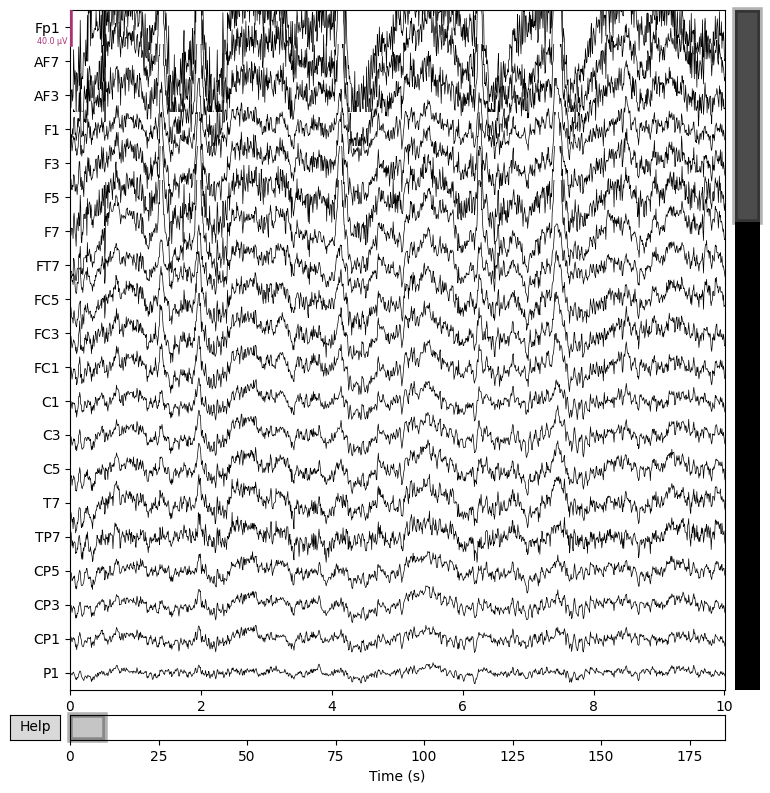

C:\Users\Neuro\AppData\Local\Temp\ipykernel_11960\1236911773.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [6]:
fig = raw.plot()
fig.set_size_inches(20, 10)
fig.suptitle('EEG - 128Hz', fontsize=14) 
ax = fig.axes[0] 
ax.set_ylabel('EEG Electrodes') 

fig.show()

Before we take a look at the raw data in non-eeg directories, let's create a function to load the data as they are all in a compressed tsv format, and may have 1 or more columns depending on the data. 

In [32]:
def load_data_tsv(filename):
    data = pd.read_csv(filename, sep='\t', compression='gzip', header=None)
    signal = data.values  

    metadata_filename = filename.replace('.tsv.gz', '.json')
    try:
        with open(metadata_filename, 'r') as file:
            metadata = json.load(file)
        
        return signal, metadata['Columns']
    
    except:
        return signal

def load_metadata(metadata_filename):
    with open(metadata_filename, 'r') as file:
        metadata = json.load(file)
    return metadata

Loading data: Let's try this function out on ECG first. To know the description and the units of a column in the data, use the column name as the key of the metadata

In [34]:
ecg, ecg_columns = load_data_tsv(ecg_filename)
print('No of columns:', np.shape(ecg)[1])
print('Columns:', ecg_columns)

ecg_metadata = load_metadata(ecg_metadata_filename)
for col in ecg_columns:
    print(f'{col}:',ecg_metadata[col])

No of columns: 1
Columns: ['rawECG']
rawECG: {'Description': 'raw ecg value', 'Units': 'mV'}


Now let's try the same with head position data

In [37]:
head, head_columns = load_data_tsv(head_filename)
print('No of columns:', np.shape(head)[1])
print('Columns:', head_columns)

head_metadata = load_metadata(head_metadata_filename)

for col in head_columns:
    print(f'{col}:',head_metadata[col])

No of columns: 3
Columns: ['x', 'y', 'z']
x: {'Description': 'head positon in horizontal direction (x-axis)', 'Units': 'pixels'}
y: {'Description': 'head positon in vertical direction (y-axis)', 'Units': 'pixels'}
z: {'Description': 'head positon in z-direction (distance from the camera sensor)', 'Units': 'millimeters'}


And then gaze

In [36]:
gaze, gaze_columns = load_data_tsv(gaze_filename)
print('No of columns:', np.shape(gaze)[1])
print('Columns:', gaze_columns)

gaze_metadata = load_metadata(gaze_metadata_filename)

for col in gaze_columns:
    print(f'{col}:',gaze_metadata[col])

No of columns: 4
Columns: ['x', 'y', 'vdx', 'vdy']
x: {'Description': 'gaze positon in the horizontal direction (x-axis)', 'Units': 'screen pixels'}
y: {'Description': 'gaze positon in the vertical direction (y-axis)', 'Units': 'screen pixels'}
vdx: {'Description': 'visual angle in the horizontal direction (x-axis)', 'Units': 'degree'}
vdy: {'Description': 'visual angle in the vertical direction (y-axis)', 'Units': 'degree'}


Plot all raw signals together so we can visually analyse any simultaneous effects

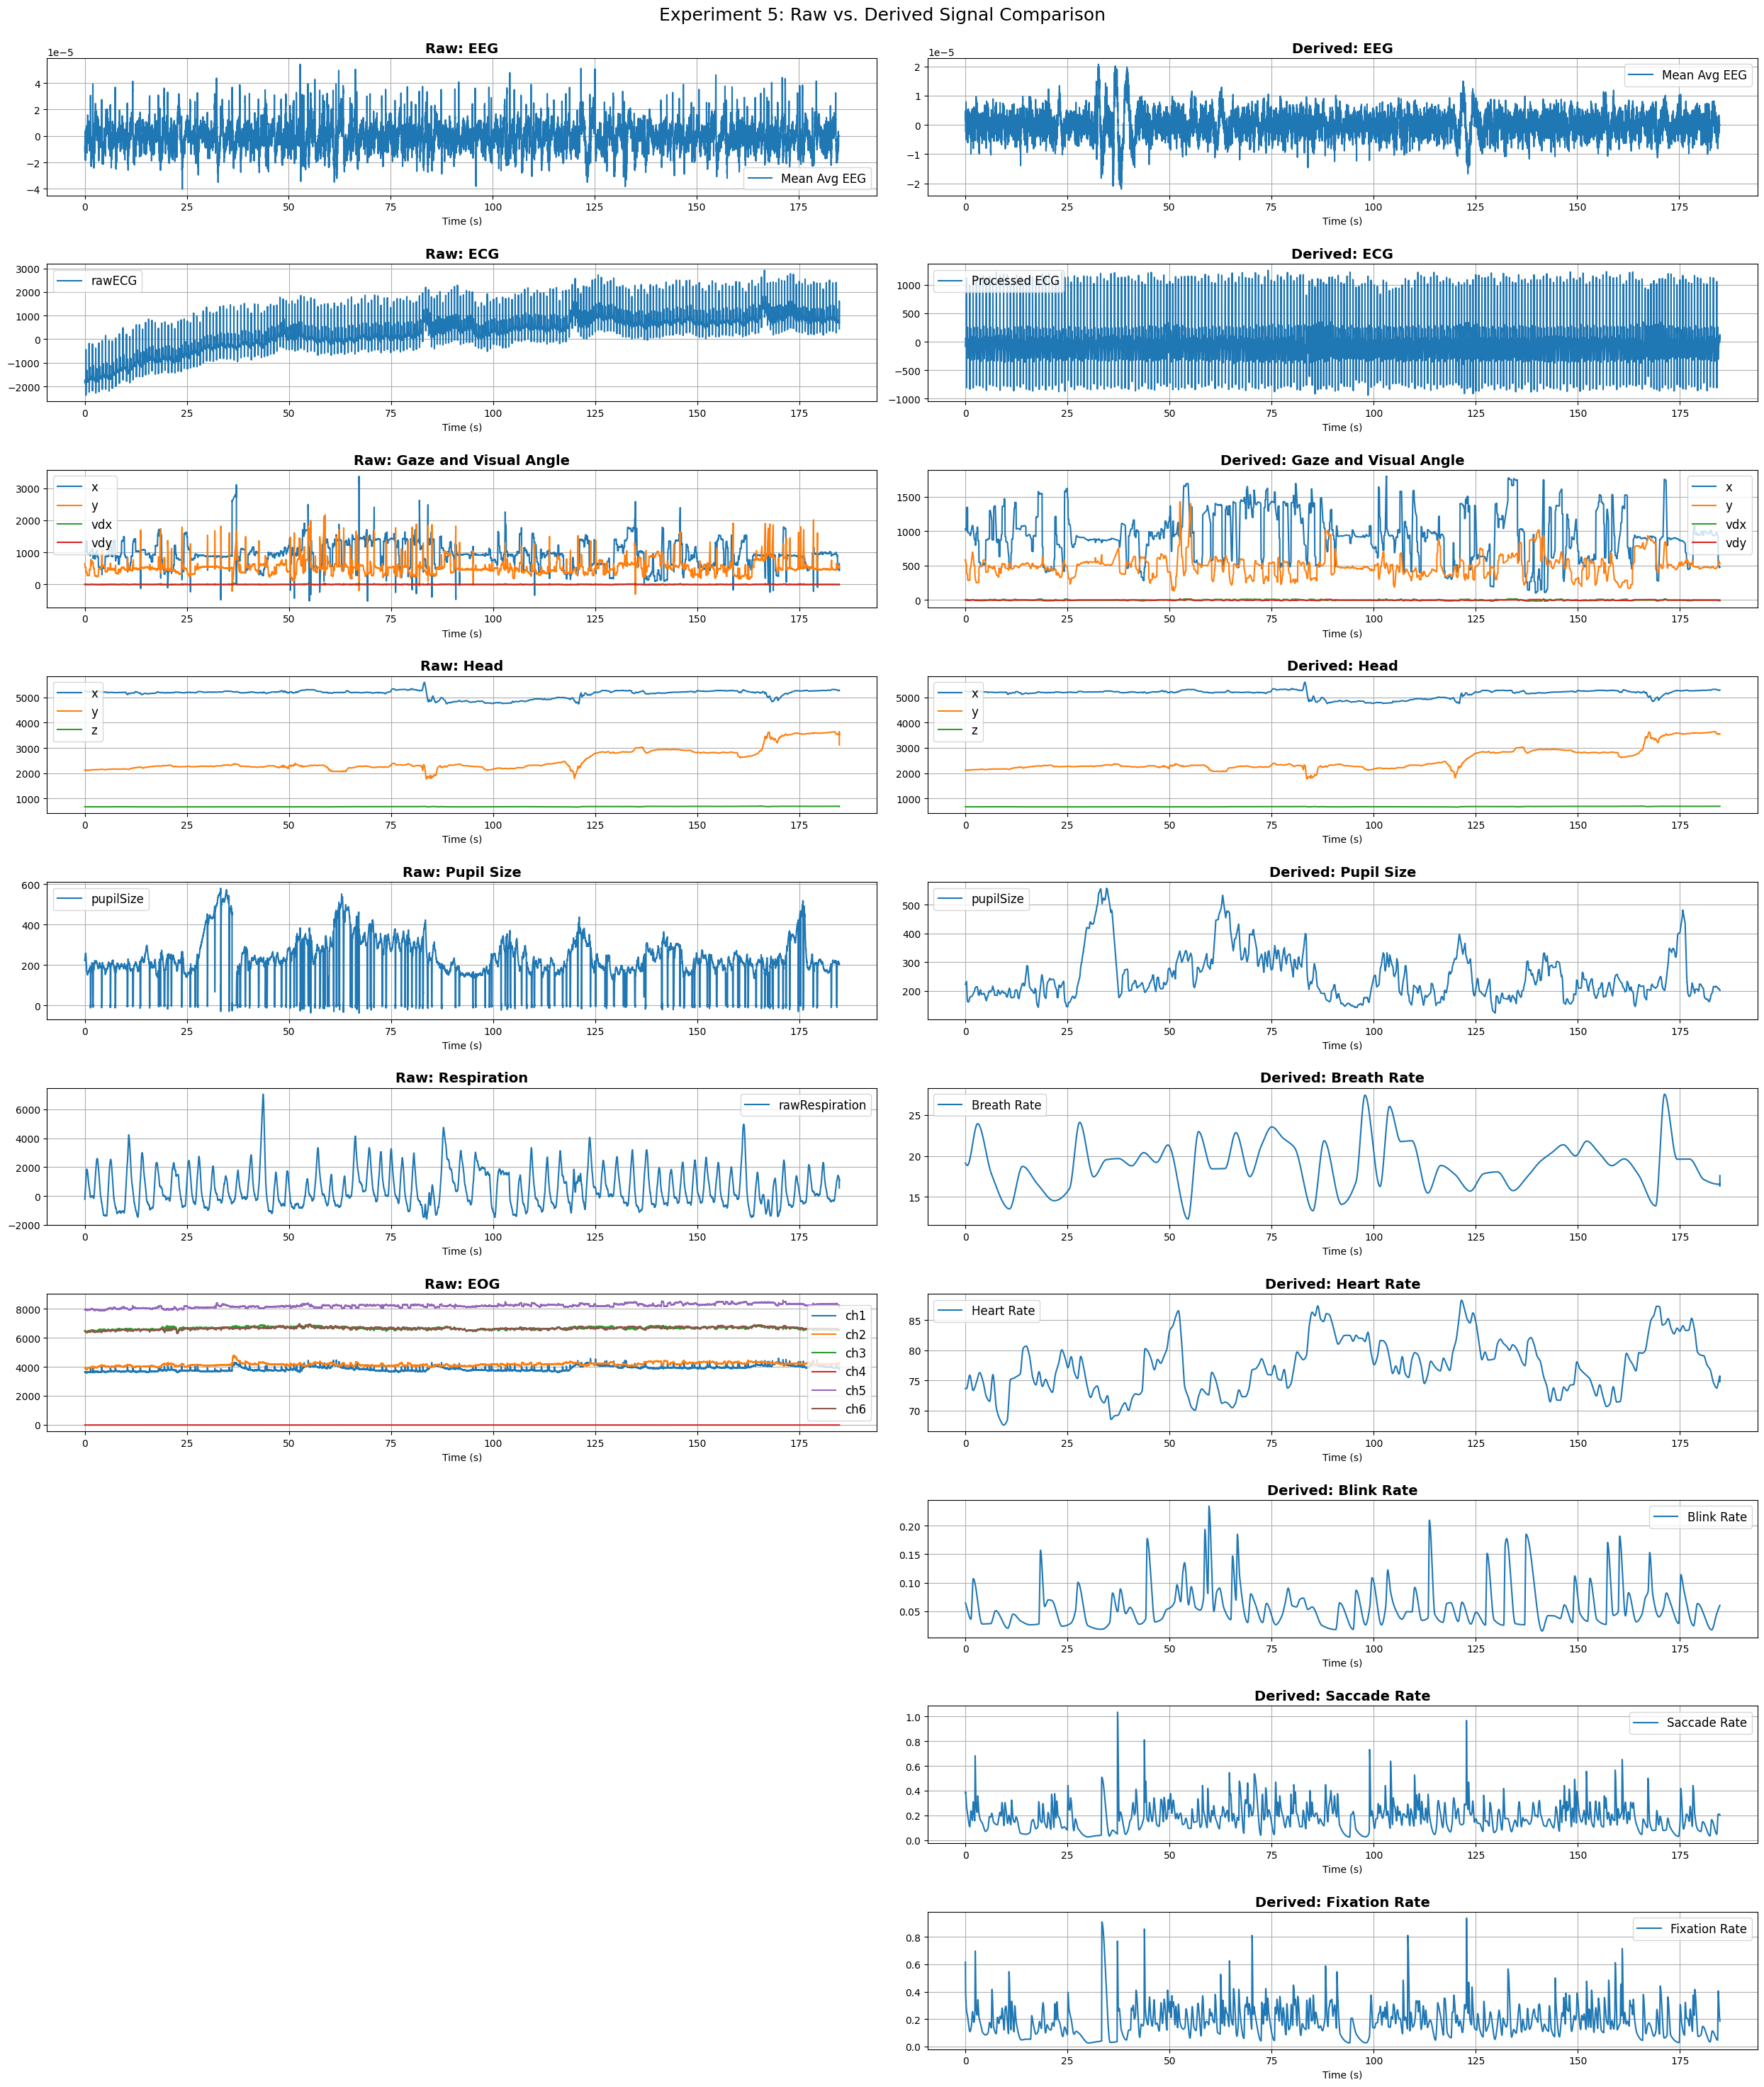

In [16]:
fs = 128  # Sampling rate (Hz)
def load_signals(filename):
    data = pd.read_csv(filename, sep='\t', compression='gzip', header=None)
    return data.values  

def load_columns(filename):
    metadata_filename = filename.replace('.tsv.gz', '.json')
    with open(metadata_filename, 'r') as file:
            metadata = json.load(file)
    return metadata['Columns']

def plot_signal(ax, data, label):
    if data is not None:
        time = np.arange(len(data)) / fs
        ax.plot(time, data)
        ax.legend(label, fontsize=12)
        ax.set_xlabel("Time (s)")
        ax.grid("on")
    else:
        ax.axis("off")

# Filenames and labels (raw vs. derived)
raw_filenames = [
    ecg_filename, gaze_filename, head_filename, pupil_filename, 
    resp_filename, eog_filename
]
raw_labels = [
    load_columns(ecg_filename), load_columns(gaze_filename), load_columns(head_filename), load_columns(pupil_filename), 
    load_columns(resp_filename), load_columns(eog_filename)
]

derived_filenames = [
    derived_ecg_filename, derived_gaze_filename, derived_head_filename, derived_pupil_filename,
    rr_file_name, hr_file_name, 
    br_file_name, sr_file_name, fr_file_name 
]
derived_labels = [
    ['Processed ECG'], load_columns(gaze_filename), load_columns(head_filename), load_columns(pupil_filename), 
    ['Breath Rate'], ['Heart Rate'], 
    ['Blink Rate'], ['Saccade Rate'], ['Fixation Rate']
]

# Load raw signals
raw_data = [load_signals(f) for f in raw_filenames]
# Add raw EEG to the beginning of this list
raw_eeg = mne.io.read_raw_bdf(eeg_filename).get_data()
raw_data.insert(0, np.mean(raw_eeg, axis=0)) # Add mean EEG
raw_labels.insert(0, ['Mean Avg EEG'])

# Load processed signals
derived_data = [load_signals(f) for f in derived_filenames]
# Add processed EEG to the beginning of this list
derived_eeg = mne.io.read_raw_bdf(derived_eeg_filename).get_data()
derived_data.insert(0, np.mean(derived_eeg, axis=0)) # Add mean EEG
derived_labels.insert(0, ['Mean Avg EEG'])

# Ensure same number of subplots 
max_len = max(len(raw_data), len(derived_data))

raw_titles = [
    ['EEG'], ['ECG'], ['Gaze and Visual Angle'], ['Head'], ['Pupil Size'], 
    ['Respiration'], ['EOG']
]

derived_titles = [
    ['EEG'], ['ECG'], ['Gaze and Visual Angle'], ['Head'], ['Pupil Size'], 
    ['Breath Rate'], ['Heart Rate'], 
    ['Blink Rate'], ['Saccade Rate'], ['Fixation Rate']
]

while len(raw_data) < max_len:
    raw_data.append(None)
    raw_labels.append("")
    raw_titles.append([""])
while len(derived_data) < max_len:
    derived_data.append(None)
    derived_labels.append("")
    derived_titles.append([""])

fig, axes = plt.subplots(max_len, 2, figsize=(25, 3 * max_len))

for i in range(max_len):
    plot_signal(axes[i, 0], raw_data[i], raw_labels[i])
    plot_signal(axes[i, 1], derived_data[i], derived_labels[i])
    
    # Set subplot titles
    if raw_data[i] is not None:
        axes[i, 0].set_title(f"Raw: {', '.join(raw_titles[i])}", fontsize=14, fontweight='bold')
    if derived_data[i] is not None:
        axes[i, 1].set_title(f"Derived: {', '.join(derived_titles[i])}", fontsize=14, fontweight='bold')

plt.suptitle("Experiment 5: Raw vs. Derived Signal Comparison\n\n", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

Plot R-Peaks and Breath Peaks

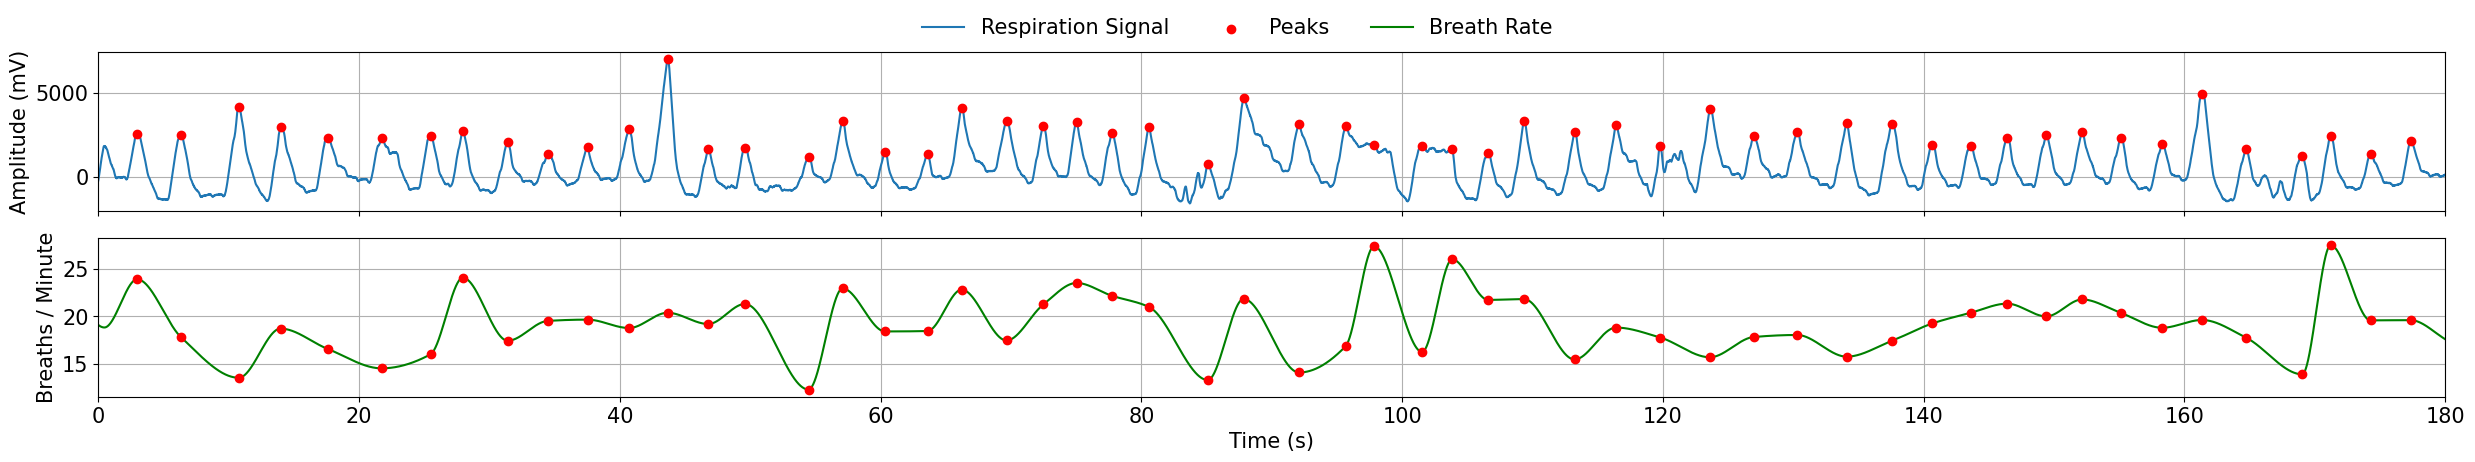

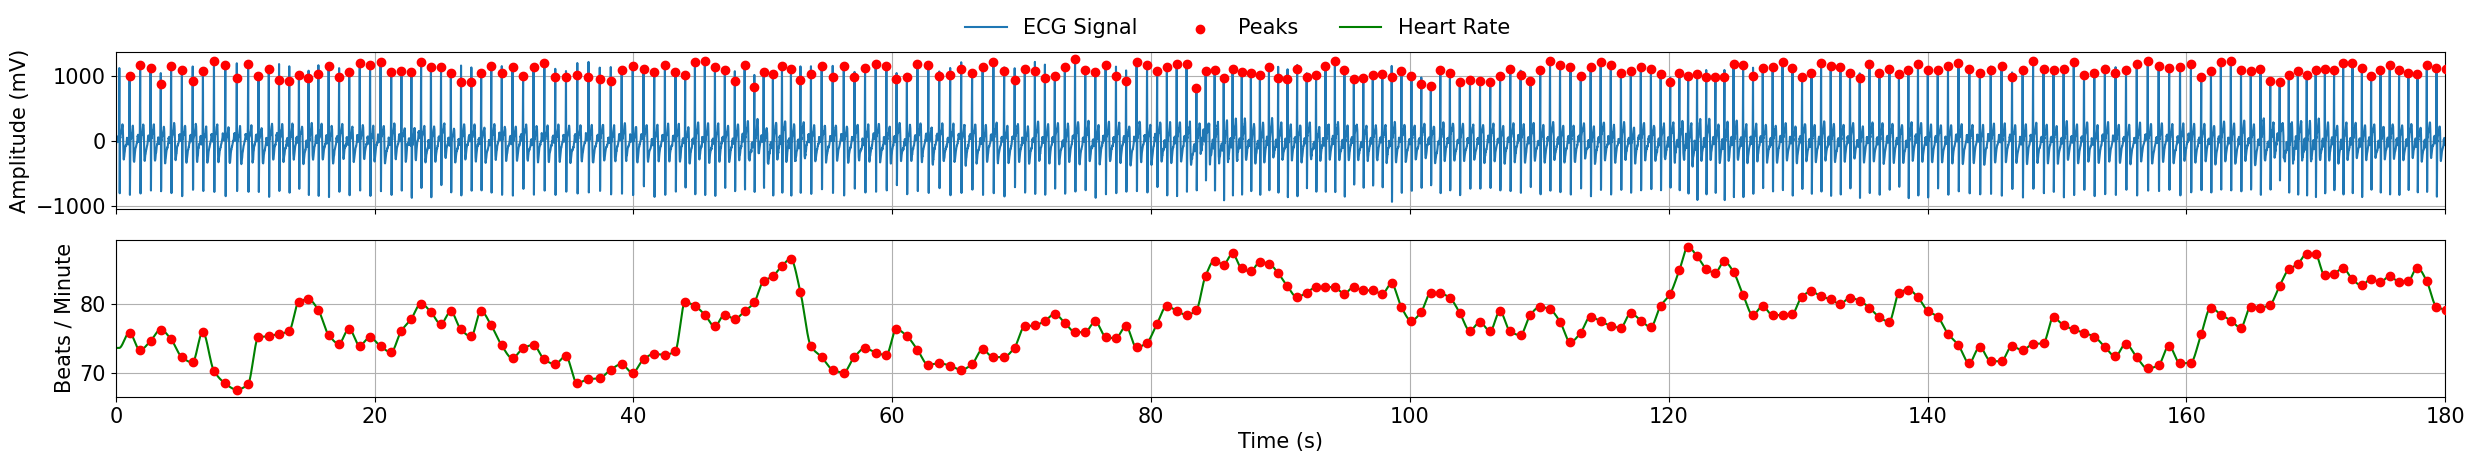

In [17]:
def load_and_plot_physio(signal_file, rate_file, peak_file, fs_signal, fs_rate, start_time, end_time, signal_label, rate_label):
    signal_df = pd.read_csv(signal_file, sep='\t', compression='gzip', header=None)
    rate_df = pd.read_csv(rate_file, sep='\t', compression='gzip')
    peak_df = pd.read_csv(peak_file, sep='\t', compression='gzip')

    signal = signal_df.values  
    rate = rate_df[1:].values
    peaks_time = peak_df[1:].values

    time_signal = np.arange(len(signal)) / fs_signal
    time_rate = np.arange(len(rate)) / fs_rate

    signal_mask = (time_signal >= start_time) & (time_signal <= end_time)
    rate_mask = (time_rate >= start_time) & (time_rate <= end_time)

    signal_segment = signal[signal_mask]
    rate_segment = rate[rate_mask]
    time_signal_segment = time_signal[signal_mask]
    time_rate_segment = time_rate[rate_mask]

    peak_indices = np.floor(peaks_time * fs_signal).astype(int)
    peak_indices = peak_indices[(peak_indices >= 0) & (peak_indices < len(signal))] 
    peak_values = signal[peak_indices]
    peak_values_rate = rate[peak_indices]

    plt.rcParams.update({'font.size': 15})
    fig, axes = plt.subplots(2, 1, figsize=(25, 5), sharex=True) 

    rate_color = 'green'
    peak_color = 'red'

    # Signal
    axes[0].plot(time_signal_segment, signal_segment, label=f"{signal_label} Signal")
    axes[0].scatter(time_signal[peak_indices], peak_values, color=peak_color, label='Peaks', zorder=5)
    axes[0].set_ylabel('Amplitude (mV)') 
    axes[0].grid(True)

    # Rate
    axes[1].plot(time_rate_segment, rate_segment, label=f"{rate_label} Rate", color=rate_color)
    axes[1].scatter(time_rate[peak_indices], peak_values_rate, color=peak_color, zorder=5)
    axes[1].set_xlabel('Time (s)')
    if rate_label == 'Breath':
        axes[1].set_ylabel(f'{rate_label}s / Minute')
    else:
        axes[1].set_ylabel(f'Beats / Minute')
    axes[1].grid(True)

    axes[0].set_xlim(start_time, end_time)

    lines_labels = [ax.get_legend_handles_labels() for ax in axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]  

    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3, frameon=False)
    plt.tight_layout(rect=[0, 0, 1, 0.89])  
    plt.show()

load_and_plot_physio(resp_filename, rr_file_name, breath_peak_timestamps_filename, fs_signal = 128, fs_rate = 128, start_time = 0, end_time = 180, signal_label = "Respiration", rate_label = "Breath")
load_and_plot_physio(derived_ecg_filename, hr_file_name, rpeak_timestamps_filename, fs_signal = 128, fs_rate = 128, start_time = 0, end_time = 180, signal_label = "ECG", rate_label = "Heart")

Plot Saccades, Blinks, Fixations

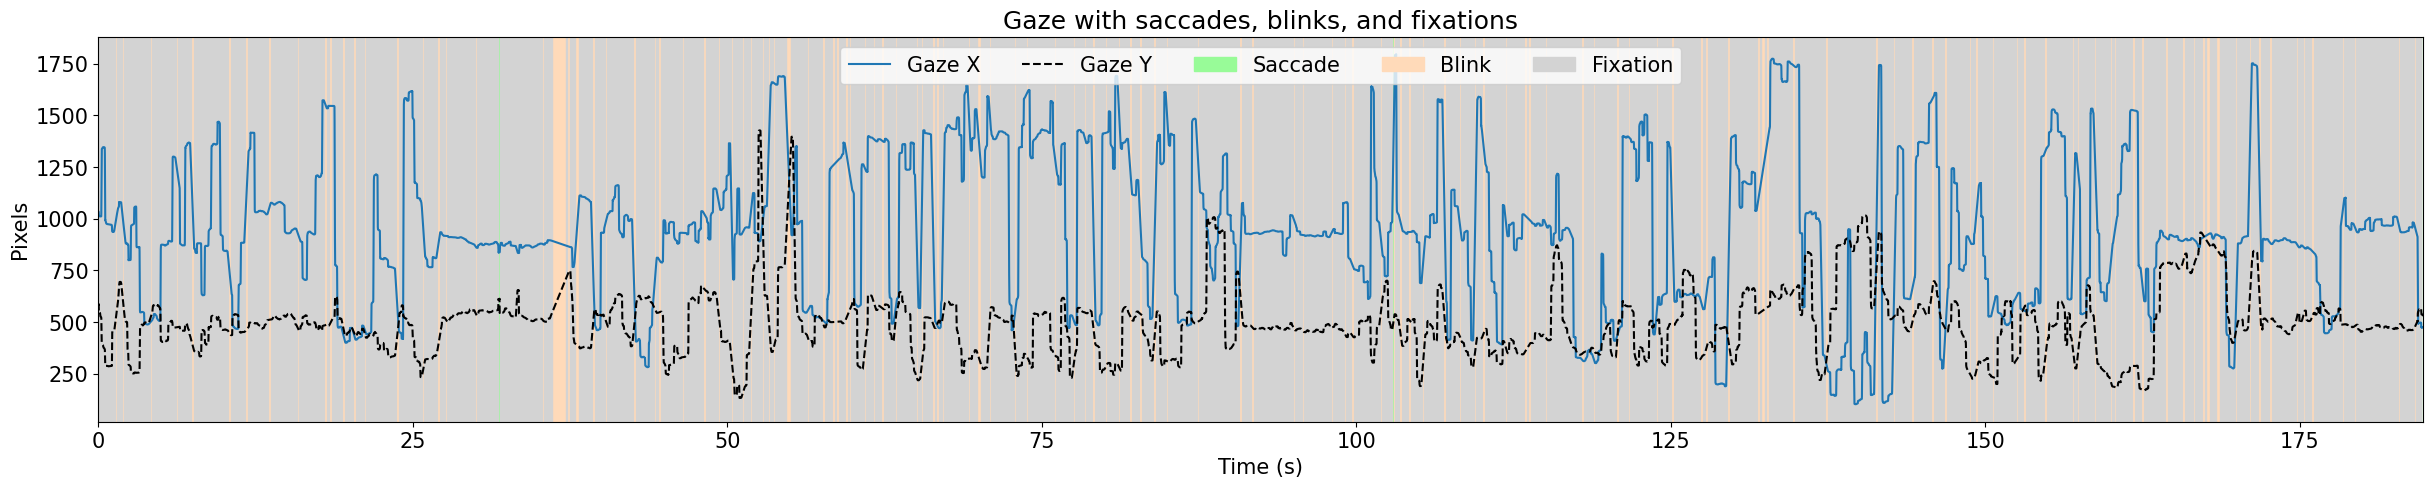

In [18]:
blinks = pd.read_csv(blink_timestamps_filename, sep='\t', compression='gzip')
saccades = pd.read_csv(saccade_timestamps_filename, sep='\t', compression='gzip')
fixations = pd.read_csv(fixation_timestamps_filename, sep='\t', compression='gzip')
gaze = load_signals(derived_gaze_filename)

gazex = np.array(gaze[:, 0])
gazey = np.array(gaze[:, 1])

time_array = np.arange(len(gazex)) / fs

# Plot gazex data for the segment
plt.figure(figsize=(30, 5))
plt.plot(time_array, gazex, label="Gaze X")  
plt.plot(time_array, gazey, label="Gaze Y", color='black', linestyle='--')  

# Flag variables to add legend labels only once per interval type
saccade_added, blink_added, fixation_added = False, False, False

# Overlay saccade intervals within the time segment
for _, row in saccades.iterrows():
    start_time = row['start_time']
    end_time = row['end_time']
    if not saccade_added:
        plt.axvspan(start_time, end_time, color='palegreen', label="Saccade")
        saccade_added = True
    else:
        plt.axvspan(start_time, end_time, color='palegreen')

# Overlay blink intervals within the time segment
for _, row in blinks.iterrows():
    start_time = row['start_time']
    end_time = row['end_time']
    if not blink_added:
        plt.axvspan(start_time, end_time, color='peachpuff', label="Blink")
        blink_added = True
    else:
        plt.axvspan(start_time, end_time, color='peachpuff')
            
# Overlay fixation intervals within the time segment
for _, row in fixations.iterrows():
    start_time = row['start_time']
    end_time = row['end_time']
    if not fixation_added:
        plt.axvspan(start_time, end_time, color='lightgrey', label="Fixation")  
        fixation_added = True
    else:
        plt.axvspan(start_time, end_time, color='lightgrey')

plt.xlabel("Time (s)")
plt.ylabel("Pixels")
plt.xlim([time_array.min(), time_array.max()])
plt.title("Gaze with saccades, blinks, and fixations")
plt.legend(ncol=5)  
plt.show()

Upon zooming into a specific time segment, say 55sec to 70sec, we can observe the extremely short intervals of saccades as well

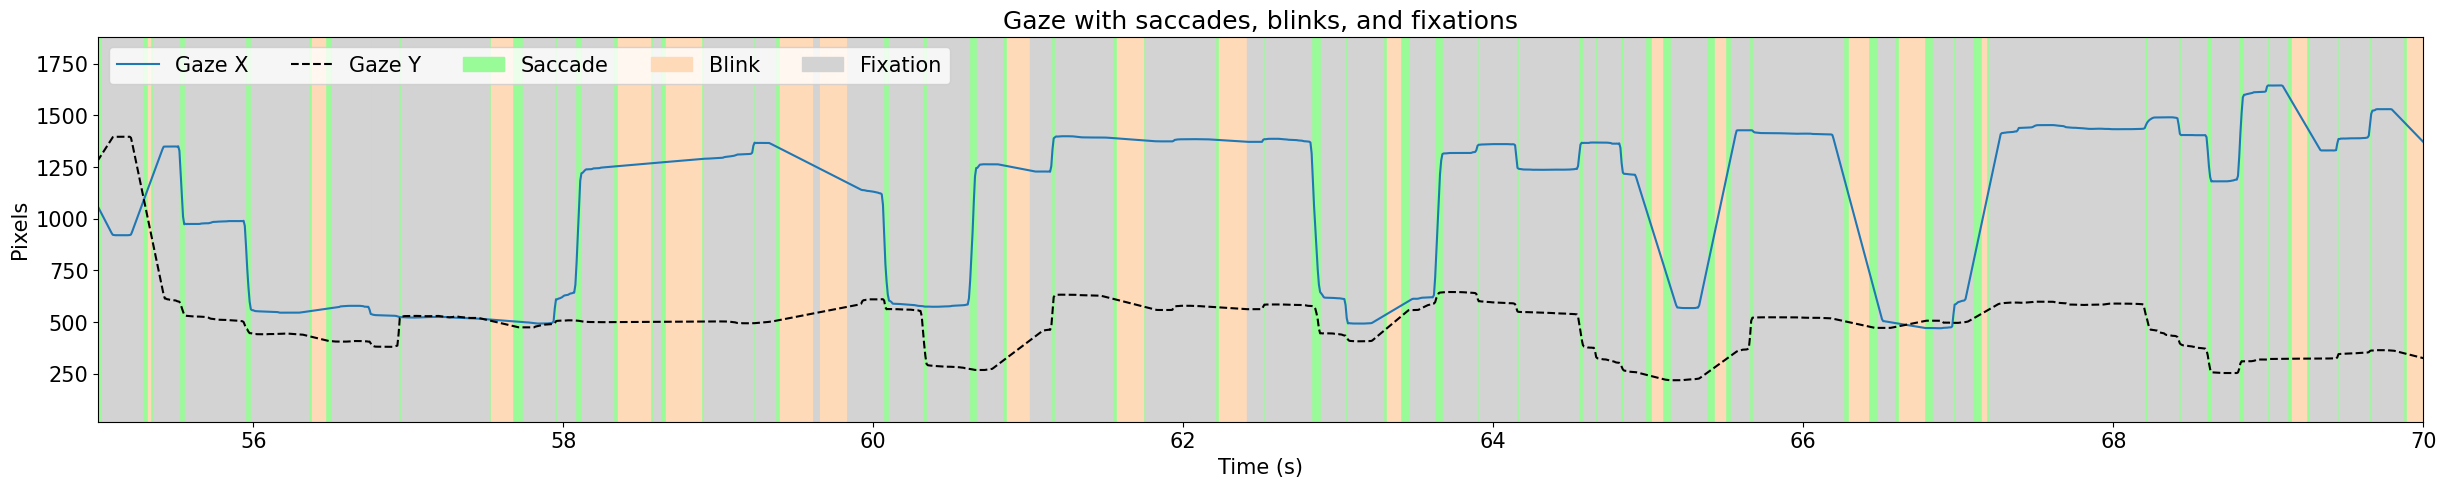

In [19]:
# Plot gazex data for the segment
plt.figure(figsize=(30, 5))
plt.plot(time_array, gazex, label="Gaze X")  
plt.plot(time_array, gazey, label="Gaze Y", color='black', linestyle='--')  

# Flag variables to add legend labels only once per interval type
saccade_added, blink_added, fixation_added = False, False, False

# Overlay saccade intervals within the time segment
for _, row in saccades.iterrows():
    start_time = row['start_time']
    end_time = row['end_time']
    if not saccade_added:
        plt.axvspan(start_time, end_time, color='palegreen', label="Saccade")
        saccade_added = True
    else:
        plt.axvspan(start_time, end_time, color='palegreen')

# Overlay blink intervals within the time segment
for _, row in blinks.iterrows():
    start_time = row['start_time']
    end_time = row['end_time']
    if not blink_added:
        plt.axvspan(start_time, end_time, color='peachpuff', label="Blink")
        blink_added = True
    else:
        plt.axvspan(start_time, end_time, color='peachpuff')
            
# Overlay fixation intervals within the time segment
for _, row in fixations.iterrows():
    start_time = row['start_time']
    end_time = row['end_time']
    if not fixation_added:
        plt.axvspan(start_time, end_time, color='lightgrey', label="Fixation")  
        fixation_added = True
    else:
        plt.axvspan(start_time, end_time, color='lightgrey')

plt.xlabel("Time (s)")
plt.ylabel("Pixels")
plt.title("Gaze with saccades, blinks, and fixations")
plt.legend(ncol=5)  
plt.xlim([55,70])
plt.show()

### HANDLING MISSING PUPIL DATA

Some "Pupil Size" and "Gaze" signals had to be interpolated because the eyetracker failed at tracking the eye at all times. We provide the timestamps (start_time, end_time) of these interpolation intervals for each of the corresponding processed pupil size and gaze files, and they can be used for visualization purposes as follows:

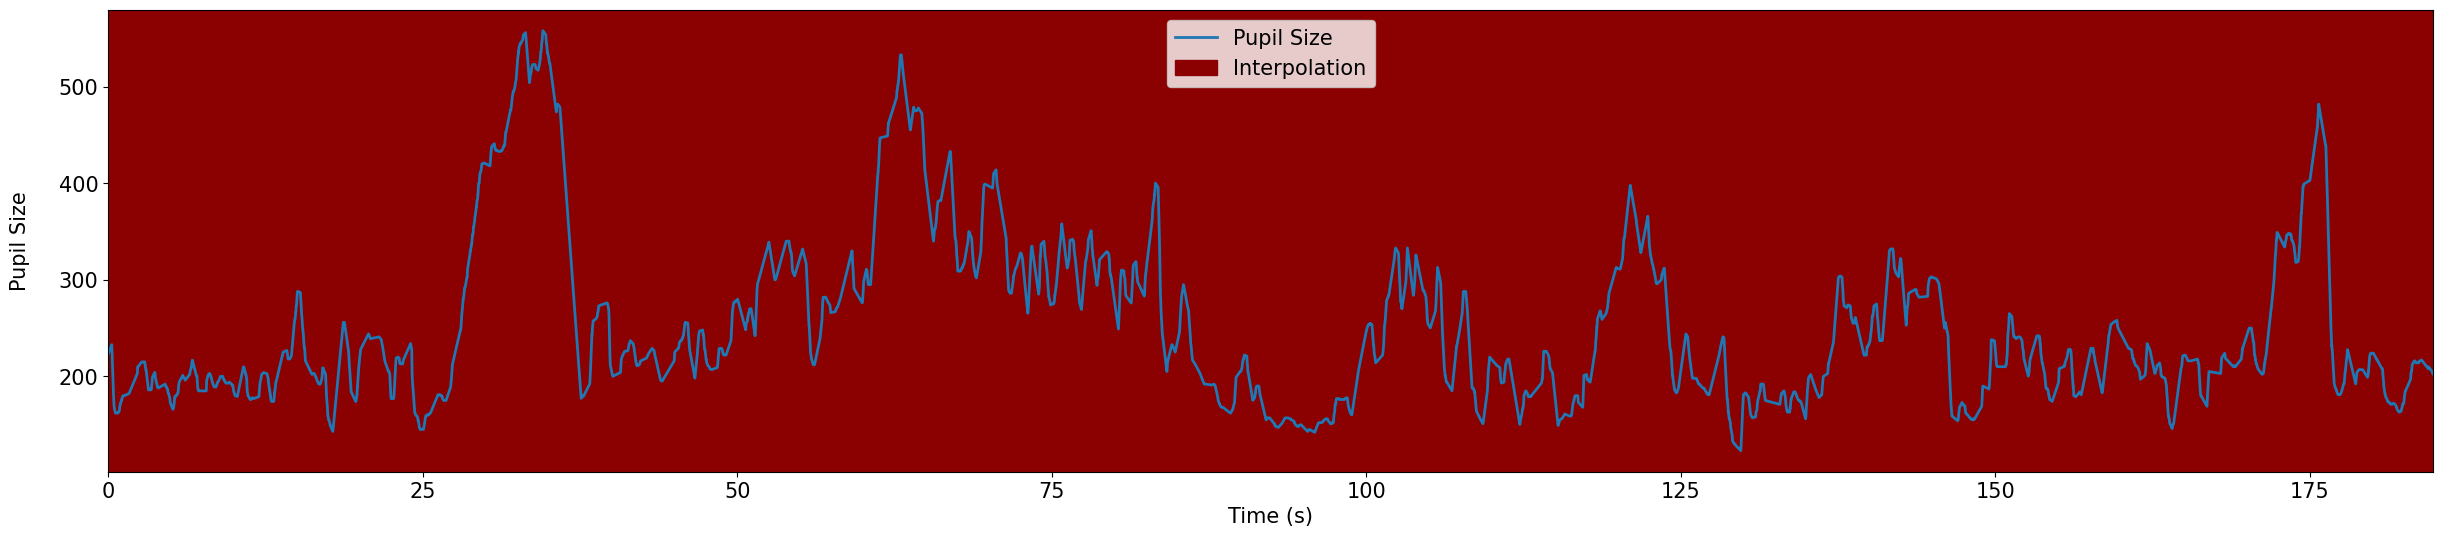

In [23]:
def plot_interpolation(pupil, pupil_interp):  
    fs = 128;  
    time_array = np.arange(len(pupil)) / fs 
    plt.figure(figsize=(30,6))
    plt.plot(time_array, pupil, linewidth=2, label="Pupil Size")
    interp_added = False
    for _, row in pupil_interp.iterrows():
        start_time = row['start_time']
        end_time = row['end_time']
        if not interp_added:
            plt.axvspan(start_time, end_time, color='darkred', label="Interpolation")
            interp_added = True
        else:
            plt.axvspan(start_time, end_time, color='darkred')
    plt.xlabel('Time (s)')
    plt.ylabel('Pupil Size\n')
    plt.xlim([0, len(pupil)/fs])
    plt.legend()
    plt.show()

exp_no = 5
sub = '11'
ses = '01'
stim = '01'

pupil_interpolated_filename = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\eyetrack\sub-{sub}_ses-{ses}_task-stim{stim}_desc-pupil_interpolation_timestamps.tsv.gz')
derived_pupil_filename = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\eyetrack\sub-{sub}_ses-{ses}_task-stim{stim}_desc-pupil_eyetrack.tsv.gz')

pupil_interp = pd.read_csv(pupil_interpolated_filename, sep='\t', compression='gzip')
pupil = load_signals(derived_pupil_filename)

plot_interpolation(pupil, pupil_interp)

As we see in the figure above, we observe that most of this signal is interpolated. Let's look at a different pupil signal from this experiment and see how it compares

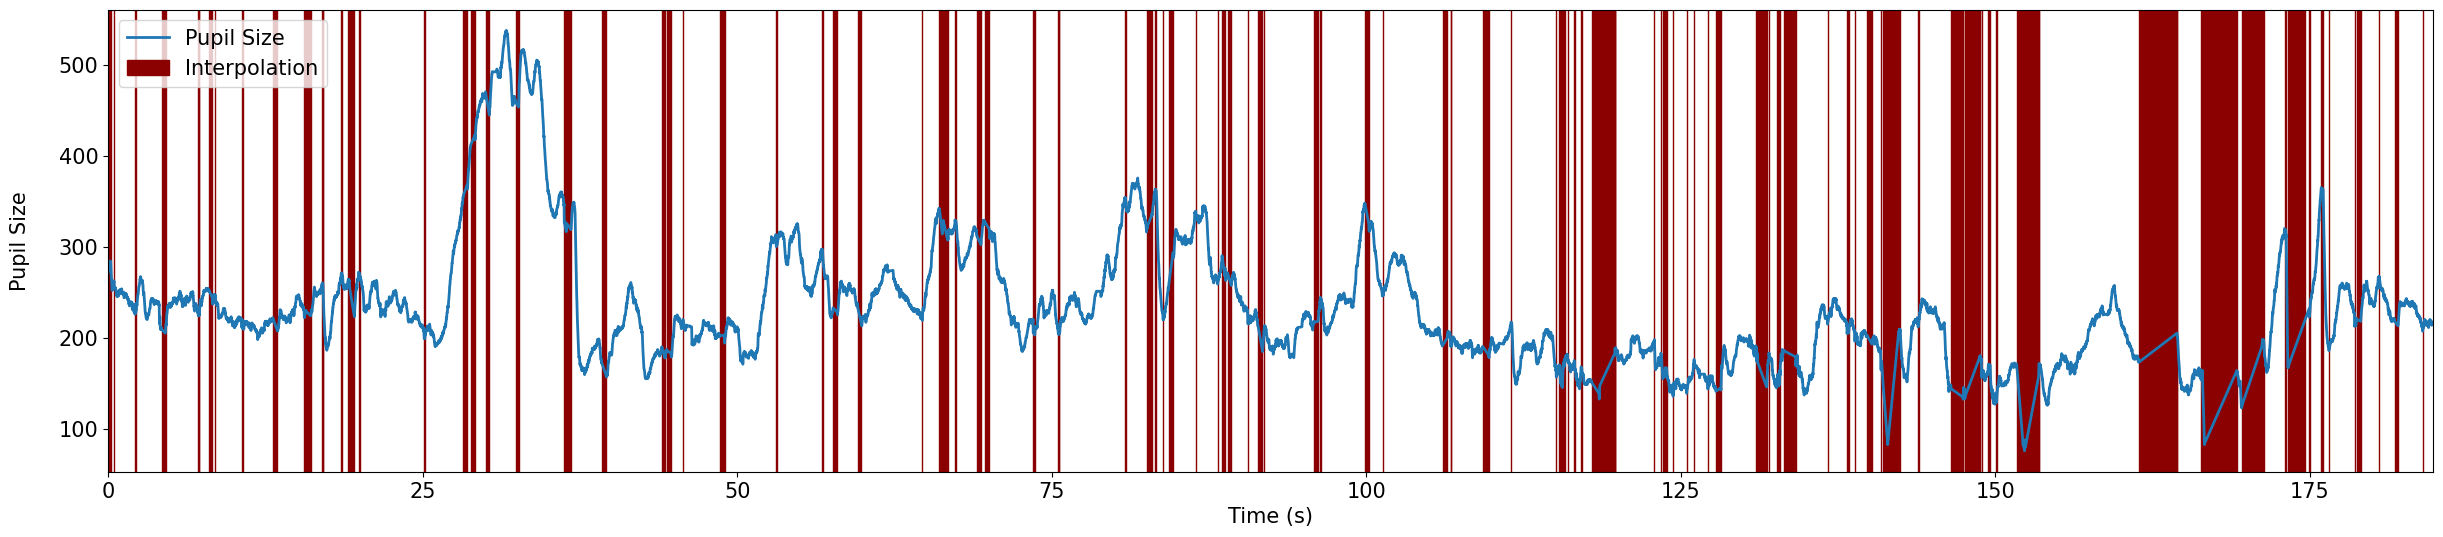

In [24]:
exp_no = 5
sub = '02'
ses = '01'
stim = '01'

pupil_interpolated_filename = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\eyetrack\sub-{sub}_ses-{ses}_task-stim{stim}_desc-pupil_interpolation_timestamps.tsv.gz')
derived_pupil_filename = os.path.join(base_dir, rf'derivatives\sub-{sub}\ses-{ses}\eyetrack\sub-{sub}_ses-{ses}_task-stim{stim}_desc-pupil_eyetrack.tsv.gz')

pupil_interp = pd.read_csv(pupil_interpolated_filename, sep='\t', compression='gzip')
pupil = load_signals(derived_pupil_filename)

plot_interpolation(pupil, pupil_interp)

The interpolation done for this signal due to missing values doesn't look as extensive as the previous file. To calculate how much %age of a pupil or eye signal has been interpolated, you can use the function below!

In [16]:
def calc_interpolation_pct(interpolated_filename, signal_filename):
    signal = load_signals(signal_filename)
    duration = len(signal)/128
    interp = pd.read_csv(interpolated_filename, sep='\t', compression='gzip')
    pct = sum(np.diff(interp))/duration
    return pct

To examine the distribution of the interpolation across the experiment, run the following cell

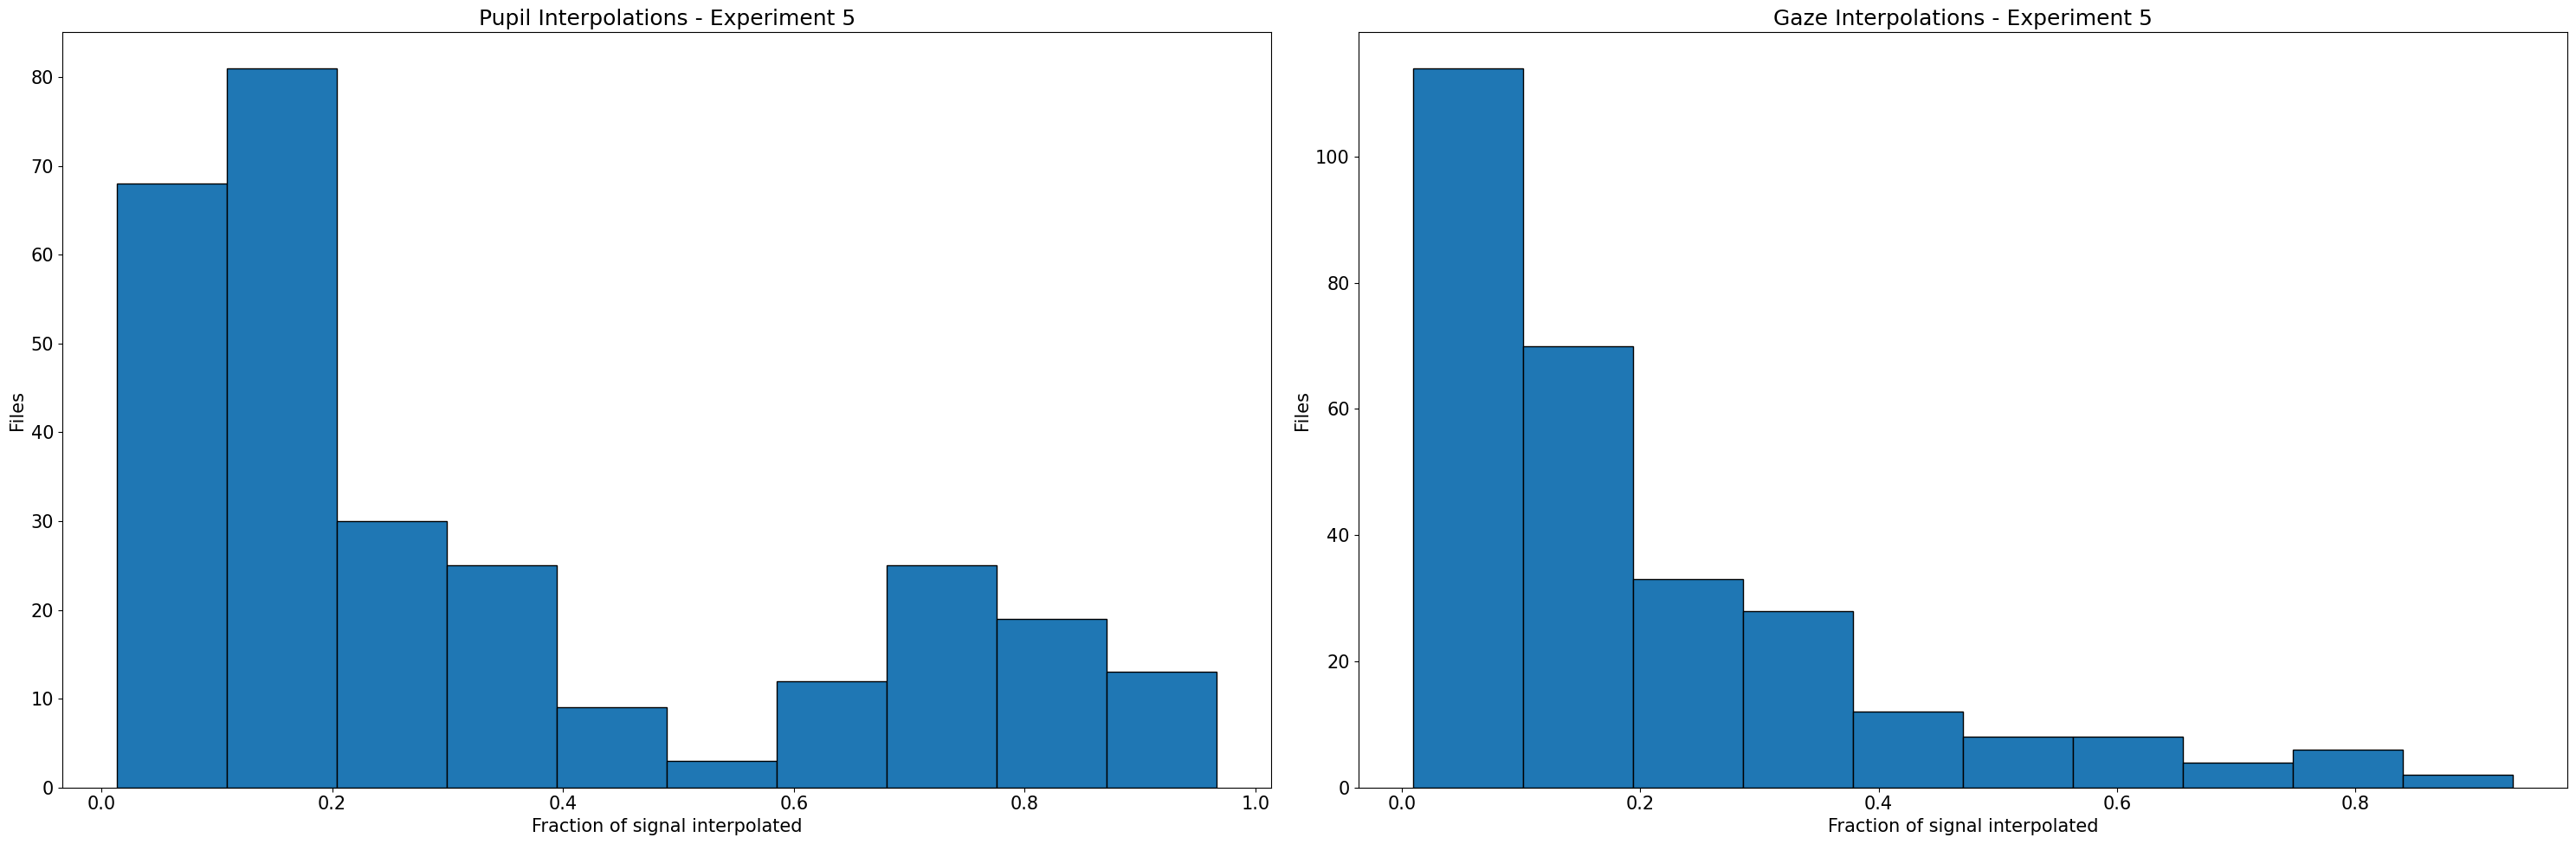

In [25]:
import glob

def interpolation_pct_list(bids_dir, signal):
    results = []
    sessions = ['ses-01', 'ses-02']
    fs = 128
    for session in sessions:
        session_path = os.path.join(bids_dir, 'derivatives', f'sub-*', session, 'eyetrack', f'*{signal}_interpolation_timestamps.tsv.gz')
        signal_path = os.path.join(bids_dir, 'derivatives', f'sub-*', session, 'eyetrack', f'*{signal}_eyetrack.tsv.gz')
        files = glob.glob(session_path)
        signal_files = glob.glob(signal_path)
        for file, signal_file in zip(files, signal_files):
            pct = calc_interpolation_pct(file, signal_file)
            results.append(pct)

    return results

pupil_interpolations = interpolation_pct_list(base_dir, 'pupil')
gaze_interpolations = interpolation_pct_list(base_dir, 'gaze')

plt.figure(figsize=(30, 10)) 
plt.subplot(1, 2, 1)
plt.hist(np.concatenate(pupil_interpolations).tolist(), bins=10, histtype='bar', edgecolor='black') 
plt.ylabel('Files')
plt.xlabel('Fraction of signal interpolated')
plt.title('Pupil Interpolations - Experiment 5')

plt.subplot(1, 2, 2)
plt.hist(np.concatenate(gaze_interpolations).tolist(), bins=10, histtype='bar', edgecolor='black')  
plt.ylabel('Files')
plt.xlabel('Fraction of signal interpolated')
plt.title('Gaze Interpolations - Experiment 5')

plt.tight_layout()  
plt.show()

In [1]:
import os

os.system('jupyter nbconvert --to html bbbd_tutorial.ipynb')

[NbConvertApp] Converting notebook bbbd_tutorial.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 9 image(s).
[NbConvertApp] Writing 3563410 bytes to bbbd_tutorial.html


0